## Importing Libraries

In [2]:
# Import Libraries
import pandas as pd
import numpy as np

import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tqdm import tqdm
import torch.nn.functional as F
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize , sent_tokenize
import nltk
from nltk.corpus import stopwords

## Loading Data

In [3]:
train_file = pd.read_csv(r"C:\Users\USER\Projects\NLP\DetectAI\data\main\final_train.csv")
train_file.head()

,text,label
0,We should keep the Electoral College for a num...,0
1,More and more money is spent on building theat...,1
2,Limiting car usage can actually be effective b...,0
3,"Dear Mrs. Smith,\n\nI am writing to you today ...",1
4,"Dear Principal,\n\nAfter school or during scho...",0


In [4]:
test_file = pd.read_csv(r"C:\Users\USER\Projects\NLP\DetectAI\data\main\final_test.csv")
test_file.head()

,text,label
0,The Face on Mars is nothing but a natural occu...,0
1,Students have a higher chance of catching a vi...,0
2,Driverless cars have good and bad things that ...,0
3,Some people might think that traveling in a gr...,1
4,How many of us students want to be forced to d...,0


## Data Analysis

In [5]:
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346977 entries, 0 to 346976
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    346977 non-null  object
 1   label   346977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ MB


In [6]:
test_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86587 entries, 0 to 86586
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    86587 non-null  object
 1   label   86587 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


## Labels

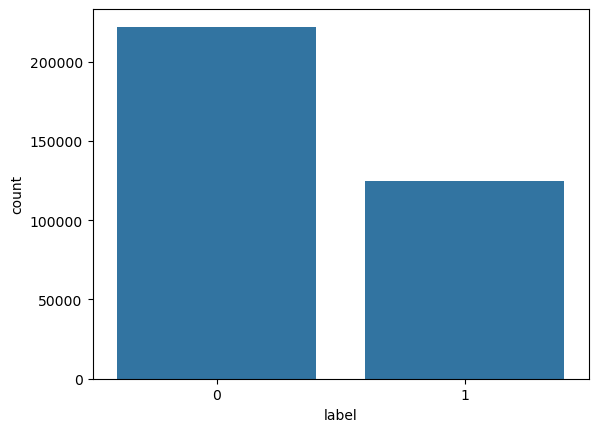

In [7]:
sns.countplot(x=train_file['label'])
plt.show()

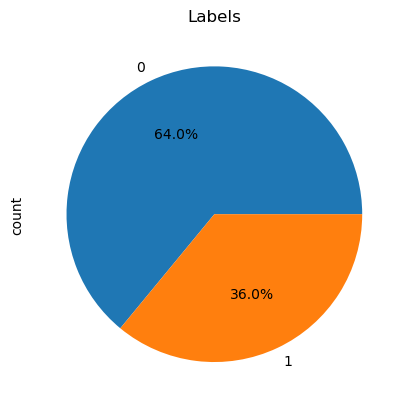

In [8]:
train_file['label'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("Labels")
plt.show()

## Gen Text

### Data Preprocessing

In [9]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

train_file['clean_text'] = train_file['text'].apply(clean_text)

In [10]:
test_file['clean_text'] = test_file['text'].apply(clean_text)

In [11]:
train_file.head()

,text,label,clean_text
0,We should keep the Electoral College for a num...,0,keep electoral college number reasons usually ...
1,More and more money is spent on building theat...,1,money spent building theaters sports stadiums ...
2,Limiting car usage can actually be effective b...,0,limiting car usage actually effective belief l...
3,"Dear Mrs. Smith,\n\nI am writing to you today ...",1,dear mrs smith writing today gave opinion new ...
4,"Dear Principal,\n\nAfter school or during scho...",0,dear principal school school activities like b...


In [12]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        # Initialize the dataset with texts, labels, tokenizer, and maximum sequence length
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        # Return the total number of samples
        return len(self.texts)

    def __getitem__(self, idx):
        # Get the text and label for the given index
        text = str(self.texts[idx])
        label = self.labels[idx]

    # Tokenize the text using the provided tokenizer
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # Return a dictionary of input IDs, attention masks, and labels
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [13]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    num_epochs=5,
    patience=2,
):
    # Initialize the best F1 score and patience counter
    best_f1 = 0
    patience_counter = 0
    best_model = None

    # Loop over each epoch
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        # Iterate over batches in the training loader
        for batch in progress_bar:
            optimizer.zero_grad()  # Reset gradients

            # Move input data and labels to the specified device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass: compute model outputs and loss
            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )
            loss = outputs.loss

            loss.backward()  # Backward pass: compute gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()  # Update model parameters
            scheduler.step()  # Update learning rate schedule

            # Update progress bar with current loss
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_preds = []
        val_labels = []

        with torch.no_grad():
            # Iterate over batches in the validation loader
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"]

                # Forward pass: compute model outputs
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Get predictions

                val_preds.extend(preds)  # Collect predictions
                val_labels.extend(labels.numpy())  # Collect true labels
        
        # Calculate F1 score for the current epoch
        current_f1 = f1_score(val_labels, val_preds)
        print(f"Epoch {epoch+1} - Validation F1: {current_f1:.4f}")

        # Check if the current F1 score is the best so far
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_model = copy.deepcopy(model)  # Save the best model
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter

        # Early stopping if no improvement for a number of epochs equal to patience
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return best_model, best_f1  # Return the best model and its F1 score


In [18]:
# Initialize tokenizer and device
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
device = torch.device("cuda")

In [15]:
# Initialize Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

In [19]:
# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(
    skf.split(train_file["clean_text"], train_file["label"])
):
    print(f"\nFold {fold + 1}")

    # Split the data into training and validation sets based on current fold indices
    train_texts = train_file["clean_text"].iloc[train_idx].values
    train_labels = train_file["label"].iloc[train_idx].values
    val_texts = train_file["clean_text"].iloc[val_idx].values
    val_labels = train_file["label"].iloc[val_idx].values

    # Create dataset objects for training and validation
    train_dataset = TextDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)

    # Create DataLoader objects for training and validation
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Initialize the BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=2
    )
    model.to(device)  # Move the model to the specified device

    # Initialize optimizer and learning rate scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=1.0, end_factor=0.01, total_iters=len(train_loader) * 5
    )

    # Train the model and obtain the best model and its F1 score
    best_model, fold_f1 = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device
    )
    f1_scores.append(fold_f1)  # Record the F1 score for the current fold

    # Clean up to free memory
    del model, best_model
    torch.cuda.empty_cache()


Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 15/17349 [03:51<74:26:45, 15.46s/it, loss=0.6722]


KeyboardInterrupt: 